In [1]:
# Import necessary packages
using SparseArrays
using StaticArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK

using Printf

include("Grid.jl")
include("Stokes.jl")

unpack (generic function with 1 method)

# Chapter 8

This code solves something "close" to Gerya's Problem 8.4. I introduce markers. The code below defines the markers, which are held in a data structure. I try to modularize all of the actions involving locating the markers, interpolating properties between the markers and the regular grid, and moving the markers.

In [2]:
mutable struct Markers    
    x::Array{Float64,2}
    cell::Array{Int,2}
    rho::Array{Float64,1}
    eta::Array{Float64,1}
    nmark::Integer
    
    function Markers(grid::CartesianGrid; nmx::Integer=5,nmy::Integer=5,random::Bool=false)
        N = nmx*nmy*grid.nx*grid.ny
        mdx = grid.W/nmx/(grid.nx-1)
        mdy = grid.H/nmy/(grid.ny-1)
                
        x = Array{Float64,2}(undef,2,N)
        cell = Array{Int,2}(undef,2,N)
        rho = Array{Float64,1}(undef,N)
        eta = Array{Float64,1}(undef,N)
        
        k=1
        for i in 1:(grid.ny-1)
            for j in 1:(grid.nx-1)
                for ii in 1:nmy
                     for jj in 1:nmx
                        x[1,k] = mdx/2. + mdx*(jj-1) + mdx*nmx*(j-1) + ( random ? (rand()-0.5)*mdx : 0.0 )
                        x[2,k] = mdy/2. + mdy*(ii-1) + mdy*nmy*(i-1) + ( random ? (rand()-0.5)*mdy : 0.0 )
                        cell[1,k] = j
                        cell[2,k] = i
                        rho[k] = 0.0
                        k+=1
                    end
                end
            end
        end

        new(x,cell,rho,eta,k-1)
    end
end

In [7]:
function find_cell(x::Float64,gridx::Vector{Float64},nx::Int ; guess::Integer=nothing)
    # find the cell in the array gridx that contains the current marker
    # first, see whether the initial guess is correct.
    lower::Int = 1
    upper::Int = nx
    if guess != nothing && guess >= 1 && guess < nx
        if x >= gridx[guess] && x < gridx[guess+1]
            return guess            
        elseif guess < nx-1 && x>=gridx[guess+1] && x<gridx[guess+2]
            return guess+1
        elseif guess > 1 && x < gridx[guess] && x >= gridx[guess-1]
            return guess-1
        else
            if x>=gridx[guess+1]
                lower = guess
            else
                upper = guess+1
            end
        end
     end
    # locate cell using bisection on lower,upper
    while upper-lower > 1 
        midpoint::Int = lower + floor((upper-lower)/2)
        if x >= gridx[midpoint]
            lower = midpoint
        else
            upper = midpoint
        end
    end
    return lower
end

function find_cells!(markers::Markers,grid::CartesianGrid)
   for i in 1:markers.nmark
        markers.cell[1,i] = find_cell(markers.x[1,i] , grid.x, grid.nx, guess=markers.cell[1,i])
        markers.cell[2,i] = find_cell(markers.x[2,i] , grid.y, grid.ny, guess=markers.cell[2,i])
    end
end

function initial_conditions!(markers::Markers)
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        mr = ((mx-2.5e5)^2 + (my-2.5e5)^2)^0.5
        # my initial misunderstanding of the problem setup:
        # markers.rho[i] = mx >= 200e3 && mx <= 300e3 ? 3200. : 3300.
        markers.rho[i] = mr < 1.0e5 ? 3200. : 3000.
        markers.eta[i] = mr < 1.0e5 ? 1e23 : 1e21 
    end
end

function marker_to_basic_node(m::Markers,grid::CartesianGrid)
    # move quantities from the markers to the basic nodes.
    # currently moves rho and eta.
    # returns rho, eta, each as a ny-by-nx matrix
    weights = zeros(Float64,grid.ny,grid.nx)
    field = zeros(Float64,2,grid.ny,grid.nx)
    # loop over the markers
    for i in 1:m.nmark
       # calculate weights for four surrounding basic nodes
         cellx::Int = m.cell[1,i]
         celly::Int = m.cell[2,i]
         wx = (m.x[1,i] - grid.x[cellx])/(grid.x[cellx+1]-grid.x[cellx]) # mdx/dx
         wy = (m.x[2,i] - grid.y[celly])/(grid.y[celly+1]-grid.y[celly])
         #i,j
         wt_i_j=(1.0-wx)*(1.0-wy)
         field[1,celly,cellx] += wt_i_j*m.rho[i]
         field[2,celly,cellx] += wt_i_j*m.eta[i]
         weights[celly,cellx] += wt_i_j
         #i+1,j
         wt_i1_j = (1.0-wx)*(wy)
         field[1,celly+1,cellx] += wt_i1_j*m.rho[i]
         field[2,celly+1,cellx] += wt_i1_j*m.eta[i]
         weights[celly+1,cellx] += wt_i1_j
         #i,j+1
         wt_i_j1 = (wx)*(1.0-wy)
         field[1,celly,cellx+1] += wt_i_j1*m.rho[i]
         field[2,celly,cellx+1] += wt_i_j1*m.eta[i]
         weights[celly,cellx+1] += wt_i_j1
         #i+1,j+1
         wt_i1_j1 = (wx)*(wy)
         field[1,celly+1,cellx+1] += wt_i1_j1*m.rho[i]
         field[2,celly+1,cellx+1] += wt_i1_j1*m.eta[i]
         weights[celly+1,cellx+1] += wt_i1_j1       
    end
    field[1,:,:] = field[1,:,:] ./ weights
    field[2,:,:] = field[2,:,:] ./ weights
    
    return field[1,:,:],field[2,:,:]
end

function basic_node_to_markers!(m::Markers,grid::CartesianGrid,field::Matrix)
    for i in 1:m.nmark
        cellx = m.cell[1,i]
        celly = m.cell[2,i]
        wx::Float64 = (m.x[1,i] - grid.x[cellx])/(grid.x[cellx+1]-grid.x[cellx]) # mdx/dx
        wy::Float64 = (m.x[2,i] - grid.y[celly])/(grid.y[celly+1]-grid.y[celly])
        
        m.rho[i] = (1.0-wx)*(1.0-wy)*field[celly,cellx] +
            + (wx)*(1.0-wy)*field[celly,cellx+1] +
            + (1.0-wx)*(wy)*field[celly+1,cellx] +
            + (wx)*(wy)*field[celly+1,cellx+1]
    end
end

function viscosity_to_cell_centers(grid::CartesianGrid,etas::Matrix)
    # compute the harmonic average of the viscosities at the nodal points
   etan = zeros(grid.ny,grid.nx)
    for i in 2:grid.ny
        for j in 2:grid.nx
            etan[i,j] = 1/( (1/etas[i-1,j-1] + 1/etas[i-1,j] + 1/etas[i,j-1] + 1/etas[i,j])/4. )
        end
    end
    return etan
end

function velocity_to_centers(grid::CartesianGrid,vx::Matrix,vy::Matrix)
    # compute vx and vy at cell centers
     vxc = zeros(grid.ny+1,grid.nx+1);
     vyc = zeros(grid.ny+1,grid.nx+1);
     # cell centers are offset in (-) direction from basic nodes.
     #               |
     # (center)     vx[i,j]
     #               |
     # ---vy[i,j]---(i,j)       
     for i in 2:grid.ny        # interior...
        for j in 2:grid.nx
            # left
            vxm = vx[i,j-1] # this will produce vx=0 along the left boundary
            vxp = vx[i,j]
            # top
            vym = vy[i-1,j] # vy=0 along the top boundary
            vyp = vy[i,j]
            vxc[i,j] = 0.5*(vxp+vxm)
            vyc[i,j] = 0.5*(vyp+vym)            
        end
    end
    # vx - top
    vxc[1,2:grid.nx] = vxc[2,2:grid.nx]
    # bottom
    vxc[grid.ny+1,2:grid.nx] = vxc[grid.ny,2:grid.nx]
    # left
    vxc[:,1] = -vxc[:,2]
    # right
    vxc[:,grid.nx+1] = - vxc[:,grid.nx]

    # vy - left
    vyc[2:grid.ny,1] = vyc[2:grid.ny,2]
    # vy - right
    vyc[2:grid.ny,grid.nx+1] = vyc[2:grid.ny,grid.nx]
    # vy - top
    vyc[1,:] = -vyc[2,:]
    # vy - bottom
    vyc[grid.ny+1,:] = -vyc[grid.ny,:]        
    
    return vxc,vyc
end

function velocity_to_points(x::Matrix,cell::Matrix,grid::CartesianGrid,vxc::Matrix,vyc::Matrix;N::Int=-1)
    # compute velocity at N points given in x (2-by-N)
    # cell should contain the cells in which the points are located (2-by-N)
    # this routine assumes that the velocity (vxc and vyc) is defined at the cell centers
    if N==-1
        N = size(x,2)
    end
    mvx = Array{Float64,1}(undef,N) # velocities at specified locations
    mvy = Array{Float64,1}(undef,N) 
    for i in 1:N
        cellx::Int = x[1,i] < grid.xc[cell[1,i]+1] ? cell[1,i] : cell[1,i] + 1
        celly::Int = x[2,i] < grid.yc[cell[2,i]+1] ? cell[2,i] : cell[2,i] + 1
        mdx::Float64 = (x[1,i] - grid.xc[cellx])/(grid.xc[cellx+1]-grid.xc[cellx])
        mdy::Float64 = (x[2,i] - grid.yc[celly])/(grid.yc[celly+1]-grid.yc[celly])
        mvx[i] = (1-mdx)*(1-mdy)*vxc[celly,cellx] +
            + (mdx)*(1-mdy)*vxc[celly,cellx+1] +
            + (1-mdx)*(mdy)*vxc[celly+1,cellx] +
            + (mdx)*(mdy)*vxc[celly+1,cellx+1]
        mvy[i] = (1-mdx)*(1-mdy)*vyc[celly,cellx] +
            + (mdx)*(1-mdy)*vyc[celly,cellx+1] +
            + (1-mdx)*(mdy)*vyc[celly+1,cellx] +
            + (mdx)*(mdy)*vyc[celly+1,cellx+1]
    end    
    return mvx,mvy
end

function velocity_to_markers(m::Markers,grid::CartesianGrid,vxc::Matrix,vyc::Matrix)
    # This function expects the velocities to be defined at the cell centers. vxc and vyc should each have
    # an 'extra' column and row corresponding to the ghost degrees of freedom that are needed to interpolate
    # velocities along the bottom and left of the domain.
    mvx,mvy = velocity_to_points(m.x,m.cell,grid,vxc,vyc;N=markers.nmark)
    return mvx,mvy
    
    mvx = Array{Float64,1}(undef,m.nmark) # velocities at marker locations
    mvy = Array{Float64,1}(undef,m.nmark) 
    # interpolate x-velocity
    for i in 1:m.nmark
        cellx::Int = m.x[1,i] < grid.xc[m.cell[1,i]+1] ? m.cell[1,i] : m.cell[1,i] + 1
        celly::Int = m.x[2,i] < grid.yc[m.cell[2,i]+1] ? m.cell[2,i] : m.cell[2,i] + 1
        mdx::Float64 = (m.x[1,i] - grid.xc[cellx])/(grid.xc[cellx+1]-grid.xc[cellx])
        mdy::Float64 = (m.x[2,i] - grid.yc[celly])/(grid.yc[celly+1]-grid.yc[celly])
        mvx[i] = (1-mdx)*(1-mdy)*vxc[celly,cellx] +
            + (mdx)*(1-mdy)*vxc[celly,cellx+1] +
            + (1-mdx)*(mdy)*vxc[celly+1,cellx] +
            + (mdx)*(mdy)*vxc[celly+1,cellx+1]
        mvy[i] = (1-mdx)*(1-mdy)*vyc[celly,cellx] +
            + (mdx)*(1-mdy)*vyc[celly,cellx+1] +
            + (1-mdx)*(mdy)*vyc[celly+1,cellx] +
            + (mdx)*(mdy)*vyc[celly+1,cellx+1]
    end    
    return mvx,mvy
end

function move_markers!(markers::Markers,grid::CartesianGrid,vxc::Matrix,vyc::Matrix,dt::Float64)
    # move the markers using the 1st-order algorithm (forward Euler)
    mvx,mvy = velocity_to_markers(markers,grid,vxc,vyc)
    # determine the maximal timestep
    vxmax = maximum(abs.(mvx))
    vymax = maximum(abs.(mvy))
    for i in 1:markers.nmark
        markers.x[1,i] += dt*mvx[i]
        markers.x[2,i] += dt*mvy[i]
    end    
    find_cells!(markers,grid)
    return dt
end

function move_markers_rk2!(markers::Markers,grid::CartesianGrid,vxc::Matrix,vyc::Matrix,dt::Float64)
    # move the markers using the 2nd-order Runge-Kutta algorithm.
    # compute velocities for each marker at current position
    mvx,mvy = velocity_to_markers(markers,grid,vxc,vyc)
    # compute marker location at xA, xB
    xB = Array{Float64,2}(undef,2,markers.nmark)
    for i in 1:markers.nmark
        xB[1,i] = markers.x[1,i] + dt/2*mvx[i]
        xB[2,i] = markers.x[2,i] + dt/2*mvy[i]
    end
    # re-locate markers, which may now be in a different cell.
    cell = copy(markers.cell)
    for i in 1:markers.nmark
        cell[1,i] = find_cell(xB[1,i], grid.x, grid.nx, guess=cell[1,i])
        cell[2,i] = find_cell(xB[2,i], grid.y, grid.ny, guess=cell[2,i])
    end
    # compute velocity at xB
    mvx,mvy = velocity_to_points(xB,cell,grid,vxc,vyc)
    # Move the markers using the velocity at xB.
    for i in 1:markers.nmark
        markers.x[1,i] += dt*mvx[i]
        markers.x[2,i] += dt*mvy[i]
    end
    # re-locate markers in their new cells.
    find_cells!(markers,grid)
end

function compute_timestep(grid::CartesianGrid,vxc::Matrix,vyc::Matrix;dtmax::Float64=Inf,cfl::Float64=0.5)
    # compute the maximum timestep based on cell-centered velocities in vxc and vyc and the cfl number.
    for i in 2:grid.ny
        for j in 2:grid.nx
            dx = grid.x[j]-grid.x[j-1]
            dy = grid.y[i]-grid.y[i-1]
            dtmax = min( dtmax , cfl*dx/abs(vxc[i,j]) , cfl*dy/abs(vyc[i,j]) )                            
        end
    end
    return dtmax
end


function visualization(grid::CartesianGrid,rho::Matrix ; filename="test.vts")
    # write the visualization output from the regular grid as a .vts file.
    vtk_grid(filename, grid.x, grid.y) do vtk
        vtk["rho"] = transpose(rho) 
    end
end

visualization (generic function with 1 method)

In [8]:
# convenience functions for plotting and debugging
function draw_grid(grid::CartesianGrid ; nodes::Bool=false)
   for y in grid.y
        plot([grid.x[1],grid.x[end]],[y,y],"k")
    end
    for x in grid.x
        plot([x,x],[grid.y[1],grid.y[end]],"k") 
    end
    if nodes
        for i in 1:grid.ny
            for j in 1:grid.nx
                plot(grid.y[i],grid.xc[j],"gs")
                plot(grid.yc[i],grid.x[j],"bo")
                plot(grid.yc[i],grid.xc[j],"ro")
            end
        end
    end
end

function plots(markers::Markers,grid::CartesianGrid,rho::Matrix,time)
    @views mx = markers.x[:,1:markers.nmark]
    @views mrho = markers.rho[1:markers.nmark]
    figure()
    subplot(1,2,1)
    #pcolor(grid.x,grid.y,rho)
    scatter(mx[1,:],mx[2,:],c=mrho,s=0.1)
    colorbar()
    gca().invert_yaxis()
    title(time)
    gca().set_aspect("equal")
#     draw_grid(grid)
    
    subplot(1,2,2)
    contourf(grid.x,grid.y,rho,)
    colorbar()
    gca().invert_yaxis()
    title(time)
    gca().set_aspect("equal")
end

plots (generic function with 1 method)

# Test marker-related routines
The cell below test the marker-related routines.
1. Create markers and distribute uniformly in the domain.
2. Apply the initial conditions to the markers.
3. Calculate density at the basic nodes from the markers.
4. Interpolate the density back to the markers from the basic nodes.

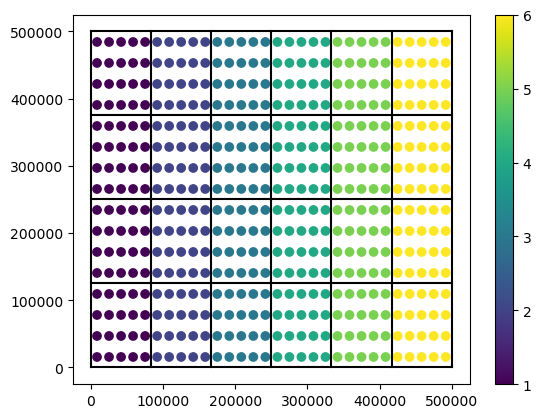

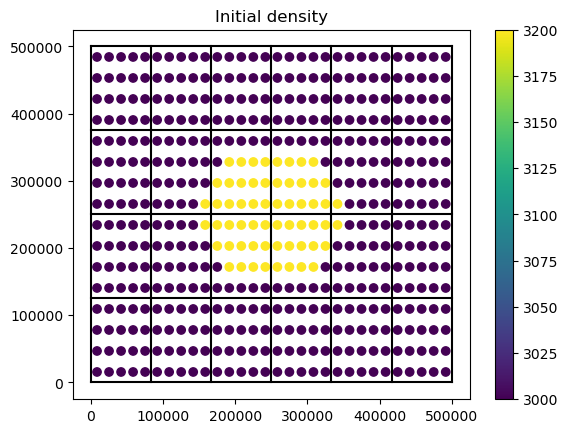

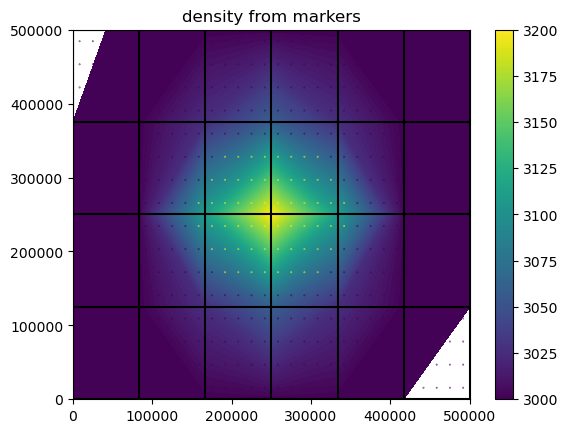

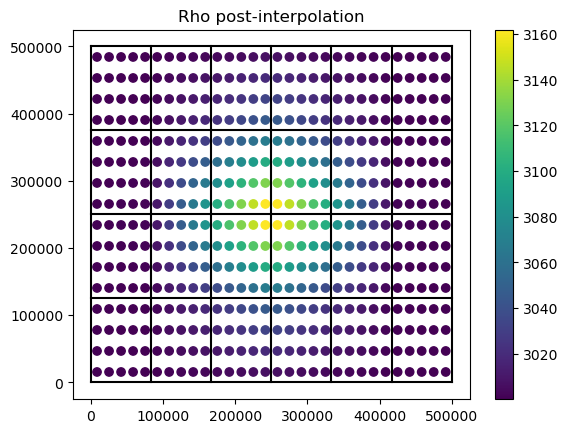

In [9]:
# Diagnostic tests on marker routines:
# Set up a grid and some markers
nx = 7
ny = 5
W = 5e5
H = 5e5
gy = -10.0
gx =  0.0
markx = 5
marky = 4
grid = CartesianGrid(W,H,nx,ny)
markers = Markers(grid;nmx=markx,nmy=marky,random=false)

mx = [markers.x[1,i] for i in 1:markers.nmark]
my = [markers.x[2,i] for i in 1:markers.nmark]
mcx = [markers.cell[1,i] for i in 1:markers.nmark]
mcy = [markers.cell[2,i] for i in 1:markers.nmark]

using PyPlot
figure()
scatter(mx,my,c=mcx)
draw_grid(grid)
colorbar()
show()

initial_conditions!(markers)

figure()
mrho = [markers.rho[i] for i in 1:markers.nmark]
scatter(mx,my,c=mrho)
draw_grid(grid)
title("Initial density")
colorbar()
show()


rho_node,eta_node = marker_to_basic_node(markers,grid)

figure()
contourf(grid.x,grid.y,rho_node,100)
mrho = [markers.rho[i] for i in 1:markers.nmark]
scatter(mx,my,c=mrho,s=0.1)
draw_grid(grid)
title("density from markers")
colorbar()
show()

basic_node_to_markers!(markers,grid,rho_node)

figure()
mrho = [markers.rho[i] for i in 1:markers.nmark]
scatter(mx,my,c=mrho)
draw_grid(grid)
title("Rho post-interpolation")
colorbar()
show()

In [ ]:
# Set up the grid
nx = 501
ny = 501
W = 5e5
H = 5e5
gy = -10.0
gx =  0.0
markx = 5
marky = 5
plot_interval = 1e6*3.15e7
last_plot = 0.0
dtmax = 5e5*3.15e7
bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.

grid = CartesianGrid(W,H,nx,ny)
println("Creating Markers...")
@time markers = Markers(grid ; nmx=markx,nmy=marky,random=true)

# Initial conditions
initial_conditions!(markers)

time = 0.0
iout=0
for itime in 0:100
    # interpolate rho and eta from markers to basic nodes
    rho,eta_s = marker_to_basic_node(markers,grid)    
    # compute eta at cell centers
    eta_n = viscosity_to_cell_centers(grid,eta_s)
    
    L,R = form_stokes(grid,eta_s,eta_n,rho,bc,gx,gy)
    solution = L\R
    vx,vy,P = unpack(solution,grid;ghost=true)
    vxc,vyc = velocity_to_centers(grid,vx,vy)
    dt = compute_timestep(grid,vxc,vyc;dtmax=dtmax)
    move_markers_rk2!(markers,grid,vxc,vyc,dt)
    #dt = move_markers!(markers,grid,vxc,vyc;dtmax=dt)
    time += dt
    if time == 0.0 || time - last_plot >= plot_interval
        last_plot = time
#         plots(markers,grid,rho,time/3.15e7/1e6)
    end
    name = @sprintf("output/viz.%04d.vtr",iout)
    visualization(grid,rho;filename=name)
    iout += 1
end

In [18]:
@sprintf("output/viz.%04d.vtr",iout)

"output/viz.0002.vtr"

In [90]:
# tests for a single step at high resolution.
nx = 1001
ny = 1001
W = 5e5
H = 5e5
gy = -10.0
gx =  0.0
markx = 5
marky = 5
plot_interval = 10
dtmax = 1e6*3.15e7

grid = CartesianGrid(W,H,nx,ny)
println("Creating Markers...")
@time markers = Markers(grid ; nmx=markx,nmy=marky,random=false)
# Initial conditions
initial_conditions!(markers)

rho,eta_s = marker_to_basic_node(markers,grid)
#eta_s = 1e21 .* ones(grid.ny,grid.nx)
eta_n = 1e21 .* ones(grid.ny,grid.nx)

# rho,eta_s,eta_n = initial_conditions(grid)
bc = BoundaryConditions(0,0,0,0)
println("forming stokes...")
@time L,R = form_stokes(grid,eta_s,eta_n,rho,bc,gx,gy)
println("solving stokes...")
@time solution = L\R
println("unpacking...")
@time vx,vy,P = unpack(solution,grid;ghost=true)
println("cell center velocities...")
vxc,vyc = velocity_to_centers(grid,vx,vy)
println("Computing timestep...")
@time dt=compute_timestep(grid,vxc,vyc)
println("advecting markers...")
@time move_markers_rk2!(markers,grid,vxc,vyc,dt)

Creating Markers...
  0.780519 seconds (34 allocations: 1.120 GiB, 8.31% gc time)
forming stokes...
  8.260984 seconds (171.73 M allocations: 4.058 GiB, 6.61% gc time)
solving stokes...
 95.699090 seconds (71 allocations: 15.065 GiB, 0.38% gc time)
unpacking...
  0.016796 seconds (10 allocations: 22.980 MiB)
cell center velocities...
Computing timestep...
  0.771378 seconds (17.96 M allocations: 274.057 MiB, 14.87% gc time, 0.49% compilation time)
advecting markers...
129.713395 seconds (2.39 G allocations: 38.650 GiB, 3.44% gc time)


In [16]:
# playing around with fieldnames to think about generalized interpolation.
getfield(markers,fieldnames(typeof(markers))[3]  )

625-element Vector{Float64}:
 3000.0
 3000.0
 3000.0
 3000.0
 3000.0
 3000.0
 3000.0
 3000.0
 3000.0
 3000.0
 3000.0
 3000.0
 3000.0
    ⋮
    4.0e-323
    1.6e-322
   -4.02133164116557e40
  NaN
    1.5e-322
    0.0
    7.73659253e-316
    8.487983164e-314
    3.2e-322
    2.3161157e-316
    6.91265698463696e-310
  NaN